# My analyse - average daily power for each type of client - Enedis France


In [953]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize']=12,5


from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_log_error
from statsmodels.tools.eval_measures import mse,rmse

# Get Data, Clean Data

## Conso

In [71]:
# Load dataset
df = pd.read_csv('bilan-electrique-transpose.csv', sep=';', parse_dates=True)

In [73]:
df['value']=df['value']/10**6
df['categorie']=df['categorie'].apply(lambda s:s.split('de la ')[1])
df['categorie']=df['categorie'].apply(lambda s:s.split(' (W)')[0])

df = df.pivot(index='jour', columns='categorie', values='value')
df.index=pd.to_datetime(df.index)
df.index.freq='D'

In [75]:
df.columns

Index(['consommation profilée BT INF 36 Professionnelle',
       'consommation profilée BT INF 36 Résidentielle',
       'consommation profilée BT SUP 36', 'consommation profilée HTA',
       'consommation totale', 'consommation totale HTA',
       'consommation télérelevée BT INF 36 Professionelle',
       'consommation télérelevée BT INF 36 Résidentielle',
       'consommation télérelevée BT SUP 36', 'consommation télérelevée HTA',
       'production autres profilée', 'production autres totale',
       'production cogénération profilée', 'production cogénération totale',
       'production hydraulique profilée', 'production profilée totale',
       'production totale', 'production télérelevée totale'],
      dtype='object', name='categorie')

In [297]:
conso=df[['consommation totale']].copy()
conso['consommation BT INF 36 Professionnelle']=df['consommation profilée BT INF 36 Professionnelle']+df['consommation télérelevée BT INF 36 Professionelle']
conso['consommation BT INF 36 Résidentielle']=df['consommation profilée BT INF 36 Résidentielle']+df['consommation télérelevée BT INF 36 Résidentielle']
conso['consommation BT SUP 36']=df['consommation profilée BT SUP 36']+df['consommation télérelevée BT SUP 36']
conso['consommation HTA']=df['consommation profilée HTA']+df['consommation télérelevée HTA']

In [79]:
(conso['consommation totale']-conso.iloc[:,1:].sum(axis=1)).describe() ##Total really represents the total

count    1.827000e+03
mean    -6.951291e-08
std      8.307389e-07
min     -2.000008e-06
25%     -1.000000e-06
50%      0.000000e+00
75%      7.275958e-12
max      3.000001e-06
dtype: float64

In [299]:
Jour=pd.DataFrame(conso.index.day_name(), index=conso.index)
Jour=pd.get_dummies(Jour).reindex(
    columns=['jour_Monday', 'jour_Tuesday', 'jour_Wednesday', 'jour_Thursday', 'jour_Friday', 'jour_Saturday', 'jour_Sunday'])
Jour

,jour_Monday,jour_Tuesday,jour_Wednesday,jour_Thursday,jour_Friday,jour_Saturday,jour_Sunday
jour,,,,,,,
2019-08-17,False,False,False,False,False,True,False
2019-08-18,False,False,False,False,False,False,True
2019-08-19,True,False,False,False,False,False,False
2019-08-20,False,True,False,False,False,False,False
2019-08-21,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...
2024-08-12,True,False,False,False,False,False,False
2024-08-13,False,True,False,False,False,False,False
2024-08-14,False,False,True,False,False,False,False


## Meteo

In [989]:
meteo=pd.read_csv('temperature-quotidienne-departementale.csv', sep=';', index_col='date_obs')
meteo.index.freq='D'

In [1048]:
meteo.index=pd.to_datetime(meteo.index)
meteo.sort_index()
S=18
meteo['tmoy']=(meteo['tmin']+meteo['tmax'])/2
meteo['DJU chauffe']=(S - meteo['tmoy']).apply(lambda x:max(0,x))
meteo['DJU refri']=(meteo['tmoy']-S).apply(lambda x:max(0,x))

In [1059]:
DJU=meteo[['DJU chauffe', 'DJU refri']].groupby(meteo.index).median()
Impact_température=' roll 3'
DJU=pd.concat([DJU, DJU.rolling(3).mean().rename(lambda x:x + Impact_température, axis='columns')], axis=1)

## Finalisation

In [1062]:
k=len(DJU.columns)

DJU=conso.join(DJU, lsuffix='jour', rsuffix='date_obs').dropna().iloc[:,-k:]
conso=conso.iloc[:len(DJU),:]
Jour=Jour.iloc[:len(DJU),:]

# EDA

In [1065]:
fig = px.line(conso)
fig.show(renderer='browser')

fig = px.line(conso.resample('ME').sum().rolling(6).mean())
fig.show(renderer='browser')

In [1066]:
from statsmodels.tsa.stattools import adfuller

def adf_test_recap(data):
    data=data[data.select_dtypes(['number']).columns] #drop non numeric values
    df = pd.DataFrame(np.zeros((2, len(data.columns))), columns=data.columns, index=list(['P-value', 'Result']))
    for c in df.columns:
            df[c].iloc[0] = adfuller(data[c].dropna(),autolag='AIC')[1] # .dropna() handles differenced data(data[c])
            df[c].iloc[1] = 'Stationary' if (df[c].iloc[0]<=0.05) else 'Non Stationary'
    
    return df

In [1034]:
adf_test_recap(conso) #Everything is almost stationary

C:\Users\natha\AppData\Local\Temp\ipykernel_6208\1329030918.py:7: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\natha\AppData\Local\Temp\ipykernel_6208\1329030918.py:8: FutureWarning:

ChainedAssignmentError: behaviour will change i

categorie,consommation totale,consommation BT INF 36 Professionnelle,consommation BT INF 36 Résidentielle,consommation BT SUP 36,consommation HTA
P-value,0.025141,0.045075,0.057849,0.003048,0.0
Result,Stationary,Stationary,Non Stationary,Stationary,Stationary


<Axes: xlabel='categorie', ylabel='categorie'>

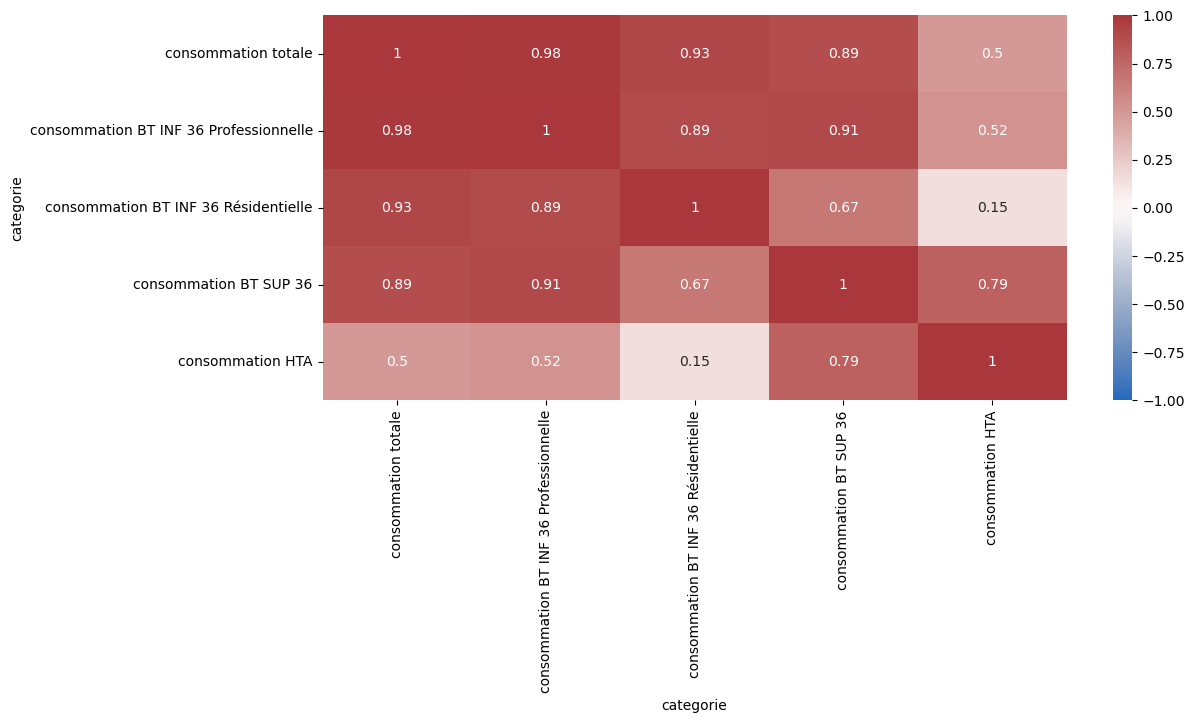

In [1069]:
sns.heatmap(conso.corr(), annot=True, cmap='vlag', vmin=-1, vmax=1)

<Axes: >

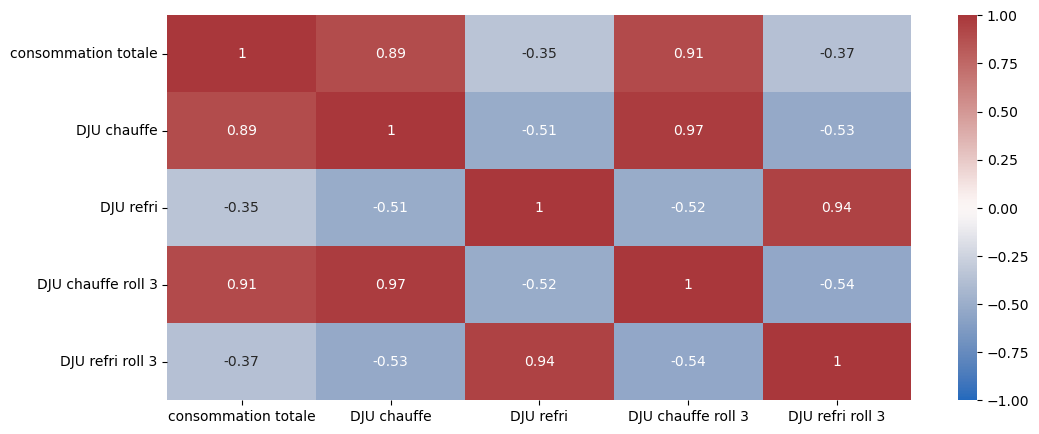

In [1071]:
sns.heatmap(pd.concat([conso['consommation totale'], DJU], axis=1).corr(), annot=True, cmap='vlag', vmin=-1, vmax=1, )

In [1093]:
def grangers_causation_matrix(data, maxlag, test='ssr_chi2test'):        
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    import seaborn as sns
    from  matplotlib.colors import LinearSegmentedColormap
    from statsmodels.tsa.stattools import grangercausalitytests

    variables=data.columns

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            df.loc[r, c] = np.min(p_values)
    df.columns = [var + '_x' for var in variables]
    df.index = [var + 'y' for var in variables]

    #Colormap

    c = ["red","palegreen", "green","darkgreen"]
    v = [0.,0.05,0.1,1.0]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('',l, N=256)


    return sns.heatmap(df, annot=True, cmap=cmap, vmin=0, vmax=1)

C:\Users\natha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\natha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\natha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\natha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\natha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\natha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\natha\anaconda3\Lib\site-packages\statsmode

<Axes: >

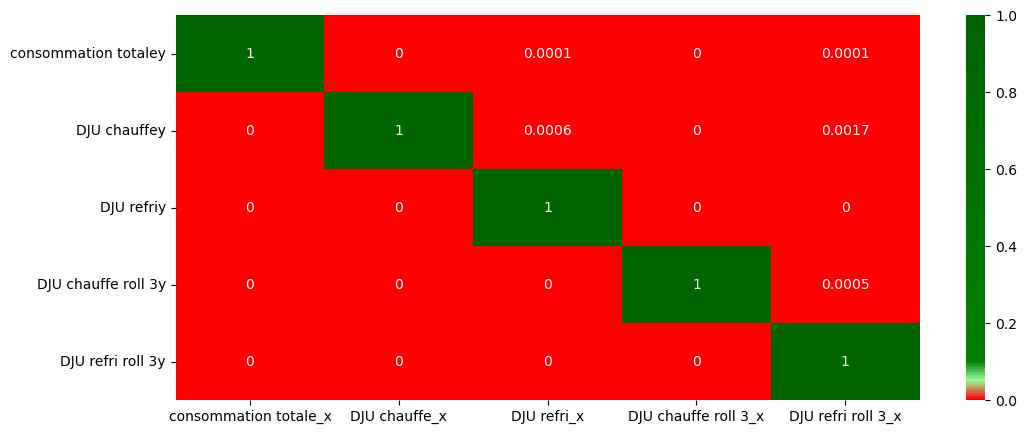

In [1095]:
grangers_causation_matrix(pd.concat([conso['consommation totale'], DJU], axis=1), maxlag=3)  

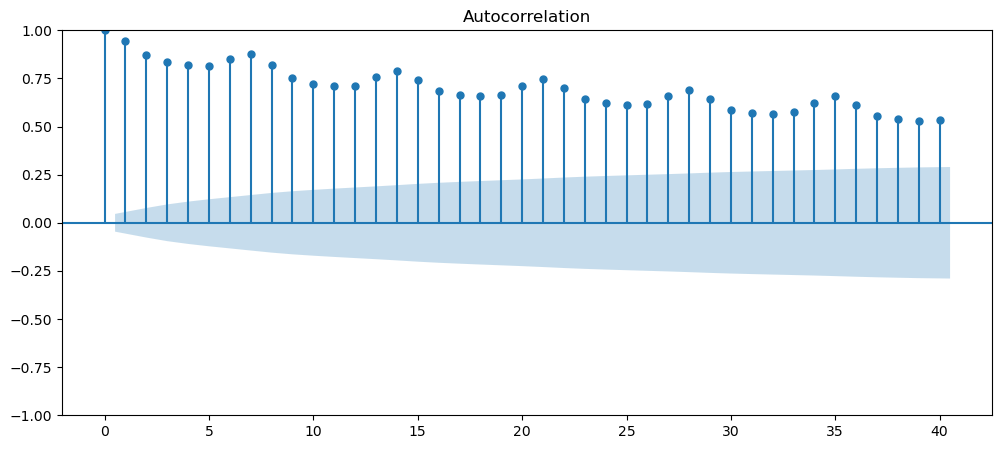

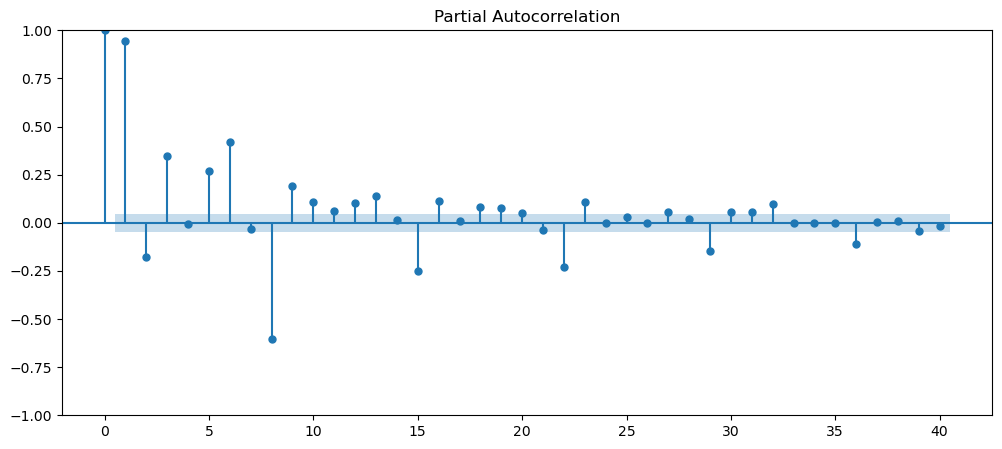

In [1097]:
lags=40

plot_acf(conso['consommation totale'],title='Autocorrelation', lags=lags);
plot_pacf(conso['consommation totale'],title='Partial Autocorrelation', lags=lags);

# --> the first most important thing to predict one day is day - 1: logical
# the second most important thing is not d-7

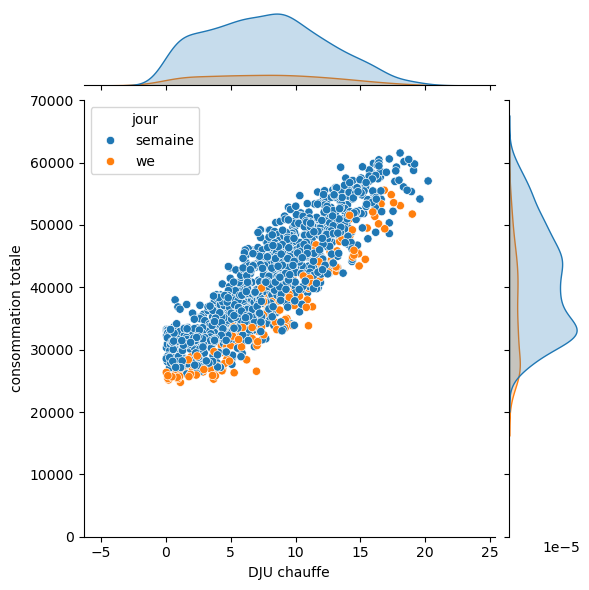

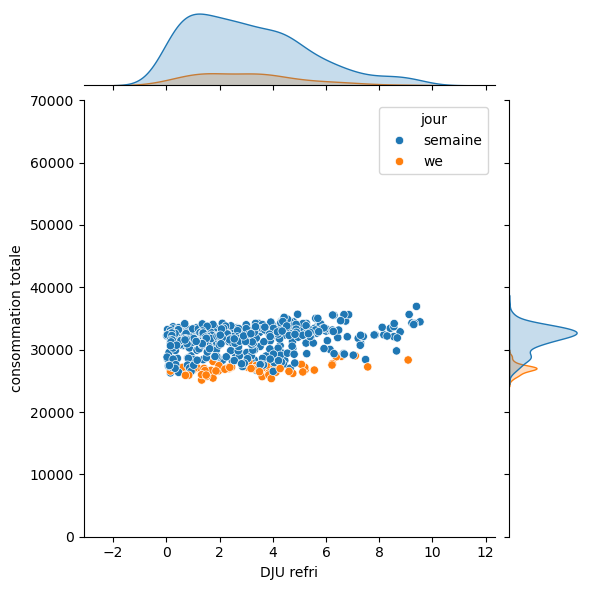

In [1099]:
plot_data=pd.concat([conso, DJU], axis=1)
sns.jointplot(plot_data[plot_data['DJU chauffe']!=0], x='DJU chauffe', y='consommation totale', 
              hue=plot_data[plot_data['DJU chauffe']!=0].index.dayofweek.map(lambda x:'semaine' if x<6 else 'we'), ylim=(0,70000))
sns.jointplot(plot_data[plot_data['DJU refri']!=0], x='DJU refri', y='consommation totale',
              hue=plot_data[plot_data['DJU refri']!=0].index.dayofweek.map(lambda x:'semaine' if x<6 else 'we'), ylim=(0,70000))

#High impact from DJU chaud, low from DJU refri

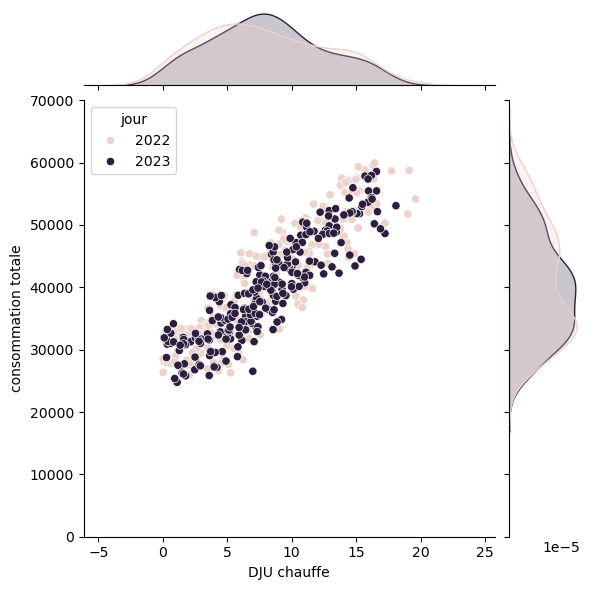

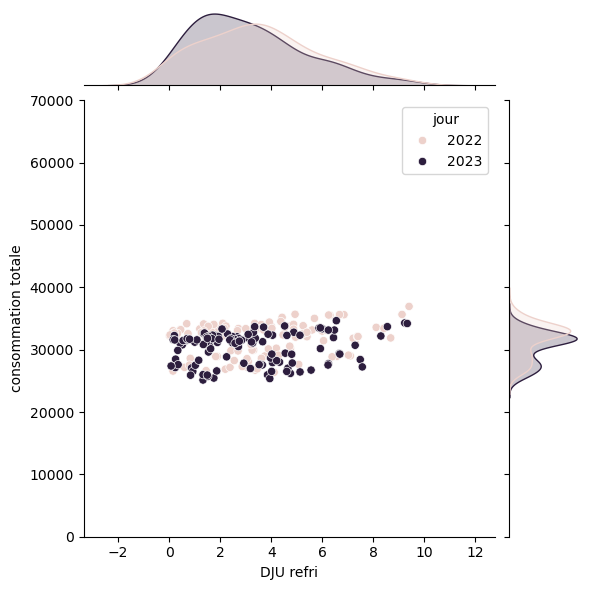

In [1101]:
plot_data=pd.concat([conso, DJU], axis=1)
plot_data=plot_data[(plot_data.index.year>2021) & (plot_data.index.year<2024)]
sns.jointplot(plot_data[plot_data['DJU chauffe']!=0], x='DJU chauffe', y='consommation totale', 
              hue=plot_data[plot_data['DJU chauffe']!=0].index.year, ylim=(0,70000))
sns.jointplot(plot_data[plot_data['DJU refri']!=0], x='DJU refri', y='consommation totale',
              hue=plot_data[plot_data['DJU refri']!=0].index.year, ylim=(0,70000))

#High impact from DJU chaud, low from DJU refri

# FORECASTNG

In [1103]:
len(conso)

1811

In [1105]:
cut=len(conso)-365*2

# Forecasting without exogenous data

## Forecasting with Prophet

In [97]:
from prophet import Prophet

In [185]:
def predict_for_Prophet(serie, cut):
  
    #Data processing
    conso_prophet=pd.DataFrame(serie)
    conso_prophet['ds']=conso_prophet.index
    conso_prophet['y']=serie
    conso_prophet=conso_prophet.reset_index().drop([serie.index.name, serie.name], axis=1)

    
    #Prediction
    m = Prophet().fit(conso_prophet[:cut])
    future = m.make_future_dataframe(periods=len(serie)-cut)

    forecast=m.predict(future)

    #Post-processing
    forecast.index=forecast['ds']
    forecast=forecast.drop('ds', axis=1)
    pred_prophet=forecast['yhat'].rename(serie.name + ' pred' )[cut:]

    #fig1 = m.plot(forecast)
    #fig2 = m.plot_components(forecast)

    #Plot for analysis

    fig1 = px.line(serie)
    fig1.update_traces(opacity=0.5)
    fig2 = px.line(forecast)
    
    fig=go.Figure(data=fig1.data+fig2.data)
    #fig.show(renderer='browser')

    return forecast, pred_prophet



In [187]:
forecast, pred_prophet = predict_for_Prophet(conso['consommation totale'], cut)
forecast.head()



16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2019-08-17,38528.586735,22965.048616,30486.884327,38528.586735,38528.586735,-11600.938054,-11600.938054,-11600.938054,-2697.553142,-2697.553142,-2697.553142,-8903.384913,-8903.384913,-8903.384913,0.0,0.0,0.0,26927.648681
2019-08-18,38521.422170,22045.019367,29406.148255,38521.422170,38521.422170,-13012.107236,-13012.107236,-13012.107236,-4183.918064,-4183.918064,-4183.918064,-8828.189172,-8828.189172,-8828.189172,0.0,0.0,0.0,25509.314934
2019-08-19,38514.257604,27390.695288,34503.493761,38514.257604,38514.257604,-7865.003432,-7865.003432,-7865.003432,872.550982,872.550982,872.550982,-8737.554413,-8737.554413,-8737.554413,0.0,0.0,0.0,30649.254172
2019-08-20,38507.093038,27756.733104,35348.639984,38507.093038,38507.093038,-6831.584852,-6831.584852,-6831.584852,1802.061540,1802.061540,1802.061540,-8633.646391,-8633.646391,-8633.646391,0.0,0.0,0.0,31675.508186
2019-08-21,38499.928472,28065.066357,35368.941191,38499.928472,38499.928472,-6869.209179,-6869.209179,-6869.209179,1649.627983,1649.627983,1649.627983,-8518.837162,-8518.837162,-8518.837162,0.0,0.0,0.0,31630.719293


In [188]:
pred_prophet_total=[]
name=[]
for serie in conso.columns:
    pred_prophet_total.append(predict_for_Prophet(conso[serie], cut)[1])
    name.append(conso[serie].name)
pred_prophet_total=pd.concat(pred_prophet_total, axis=1)    
pred_prophet_total['sum pred']=pred_prophet_total.iloc[:,1:].sum(axis=1)



16:45:40 - cmdstanpy - INFO - Chain [1] start processing
16:45:40 - cmdstanpy - INFO - Chain [1] done processing
16:45:41 - cmdstanpy - INFO - Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing
16:45:45 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing


In [189]:
fig1 = px.line(conso)
fig1.update_traces(opacity=0.5)
fig2 = px.line(pred_prophet_total)

fig=go.Figure(data=fig1.data+fig2.data)
fig.show(renderer='browser')

In [191]:
i=0
for c in pred_prophet_total.columns:
    print(pred_prophet_total[c].name + ': RMSE Error =  ' + f'{rmse(conso.iloc[cut:,i], pred_prophet_total[c]):.3f}')
    i=(i+1)%len(conso.columns)

consommation totale pred: RMSE Error =  4149.561
consommation BT INF 36 Professionnelle pred: RMSE Error =  587.492
consommation BT INF 36 Résidentielle pred: RMSE Error =  2417.070
consommation BT SUP 36 pred: RMSE Error =  1020.337
consommation HTA pred: RMSE Error =  1437.206
sum pred: RMSE Error =  4117.466


# Forecasting with exogenous data

# Baseline = Régression linéaire avec DJU chauffe et refri, jour de semaine

In [195]:
from sklearn.linear_model import LinearRegression

In [1001]:
Ldata=pd.concat([DJU, Jour], axis=1)
Lmodel = LinearRegression()
Lmodel.fit(Ldata[:cut], conso['consommation totale'][:cut])

LinearRegression()

In [1003]:
coef_df=pd.DataFrame(data=Lmodel.coef_.T, index=Ldata.columns, columns=['Coef'])
intercept_df=pd.DataFrame(data=Lmodel.intercept_, index=['Intercept'], columns=['Coef'])
log_coef=pd.concat([intercept_df, coef_df], axis=0)
log_coef


,Coef
Intercept,53851.750655
tmoy,-1169.611138
jour_Monday,679.244334
jour_Tuesday,1636.503618
jour_Wednesday,1706.097028
jour_Thursday,1782.221366
jour_Friday,1161.352621
jour_Saturday,-2744.637018
jour_Sunday,-4220.781949


In [1005]:
Lmodel.score(Ldata[:cut], conso['consommation totale'][:cut])

0.7786281653898863

In [1007]:
Lpred=pd.Series(data=Lmodel.predict(Ldata[cut:]), index=conso[cut:].index, name='Lpred')
Lpred

jour
2022-08-18    31753.436608
2022-08-19    30805.076745
2022-08-20    26706.101268
2022-08-21    27031.157490
2022-08-22    29720.618721
                  ...     
2024-07-27    25492.629712
2024-07-28    23577.880604
2024-07-29    24939.833194
2024-07-30    23560.794230
2024-07-31    24490.051826
Freq: D, Name: Lpred, Length: 714, dtype: float64

In [1009]:
print(Lpred.name + ': RMSE Error =  ' + f'{rmse(conso.iloc[cut:,0], Lpred):.3f}')


Lpred: RMSE Error =  4115.039


In [837]:
fig1 = px.line(conso['consommation totale'])
fig1.update_traces(opacity=0.5)
fig2 = px.line(Lpred)

fig=go.Figure(data=fig1.data+fig2.data)
fig.show(renderer='browser')

In [969]:
Lpred_total=[]
name=[]
to_pred=conso.iloc[:,:5]
for serie in to_pred.columns:
    Lmodel = LinearRegression().fit(Ldata[:cut], to_pred[serie][:cut])
    name=to_pred[serie].name + ' pred linear'
    Lpred_total.append(pd.Series(data=Lmodel.predict(Ldata[cut:]), index=conso[cut:].index, name=name))

Lpred_total=pd.concat(Lpred_total, axis=1)    
Lpred_total['sum pred linear']=Lpred_total.iloc[:,1:].sum(axis=1)



In [971]:
fig1 = px.line(conso)
fig1.update_traces(opacity=0.5)
fig2 = px.line(Lpred_total)

fig=go.Figure(data=fig1.data+fig2.data)
fig.show(renderer='browser')

In [972]:
i=0
for c in Lpred_total.columns:
    print(Lpred_total[c].name + ': RMSE Error =  ' + f'{rmse(conso.iloc[cut:,i], Lpred_total[c]):.3f}')
    i=(i+1)%len(to_pred.columns)

consommation totale pred linear: RMSE Error =  2577.032
consommation BT INF 36 Professionnelle pred linear: RMSE Error =  322.010
consommation BT INF 36 Résidentielle pred linear: RMSE Error =  1482.524
consommation BT SUP 36 pred linear: RMSE Error =  337.395
consommation HTA pred linear: RMSE Error =  947.669
sum pred linear: RMSE Error =  2577.032


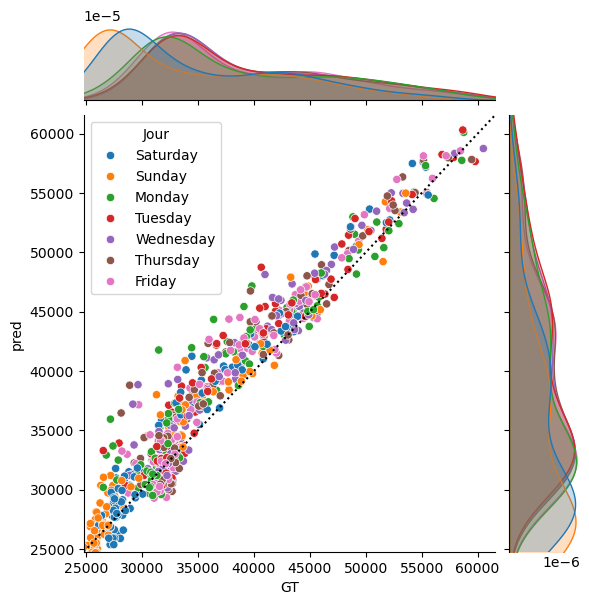

In [903]:
plot_data=pd.concat([conso['consommation totale'], Lpred], axis=1)
plot_data['Jour']=plot_data.index.day_name()
#plot_data=plot_data[plot_data['Jour']=='Sunday']

scale=(conso['consommation totale'].min(), conso['consommation totale'].max())

f=sns.jointplot(x=plot_data.iloc[:,0], y=plot_data.iloc[:,1],  xlim=scale, ylim=scale, hue=plot_data.iloc[:,2])
f.set_axis_labels(xlabel='GT', ylabel='pred')
f.ax_joint.plot([0, 1], [0, 1], ':k', transform=f.ax_joint.transAxes)

<Axes: xlabel='None', ylabel='Count'>

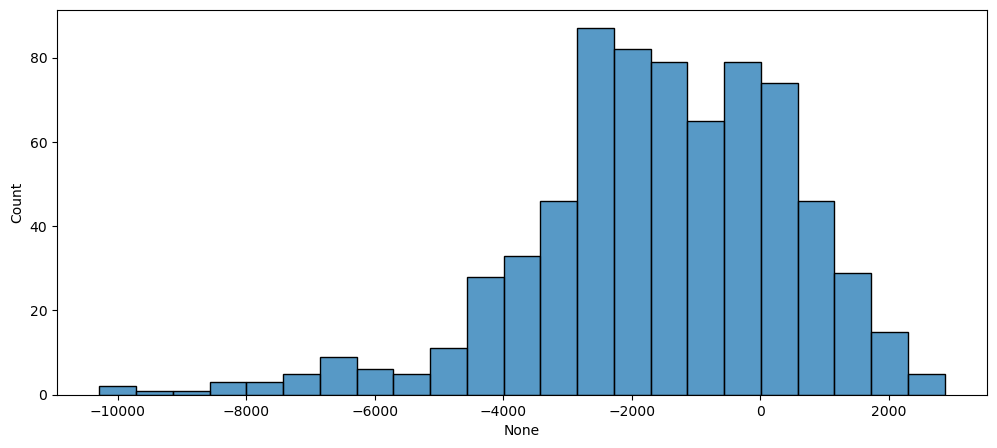

In [907]:
sns.histplot(x=plot_data.iloc[:,0]-plot_data.iloc[:,1])

## Forecasting with Prophet

In [247]:
def predict_for_Prophet_with_eX(serie, cut, eX):

    
    #Data processing
    conso_prophet=pd.DataFrame(serie)
    conso_prophet['ds']=conso_prophet.index
    conso_prophet['y']=serie
    
    conso_prophet=pd.concat([conso_prophet,eX], axis=1)
    conso_prophet=conso_prophet.reset_index().drop([serie.index.name, serie.name], axis=1)
    #Prediction
    m = Prophet()
    for c in eX.columns: m.add_regressor(eX[c].name)

    m.fit(conso_prophet[:cut])
    future = m.make_future_dataframe(periods=len(serie)-cut)
    future=pd.concat([future, conso_prophet.iloc[:,2:]], axis=1)
    
    forecast=m.predict(future)

    #Post-processing
    forecast.index=forecast['ds']
    forecast=forecast.drop('ds', axis=1)
    pred_prophet=forecast['yhat'].rename(serie.name + ' pred with T' )[cut:]

    #fig1 = m.plot(forecast)
    #fig2 = m.plot_components(forecast)

    #Plot for analysis

    fig1 = px.line(serie)
    fig1.update_traces(opacity=0.5)
    fig2 = px.line(forecast)
    
    fig=go.Figure(data=fig1.data+fig2.data)
    #fig.show(renderer='browser')

    return forecast, pred_prophet

In [1011]:
eX=pd.concat([DJU, Jour], axis=1)

forecast_T, pred_prophet_T = predict_for_Prophet_with_eX(conso['consommation totale'], cut, eX)
forecast.head()

19:01:27 - cmdstanpy - INFO - Chain [1] start processing
19:01:27 - cmdstanpy - INFO - Chain [1] done processing


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2019-08-17,38528.586735,22965.048616,30486.884327,38528.586735,38528.586735,-11600.938054,-11600.938054,-11600.938054,-2697.553142,-2697.553142,-2697.553142,-8903.384913,-8903.384913,-8903.384913,0.0,0.0,0.0,26927.648681
2019-08-18,38521.422170,22045.019367,29406.148255,38521.422170,38521.422170,-13012.107236,-13012.107236,-13012.107236,-4183.918064,-4183.918064,-4183.918064,-8828.189172,-8828.189172,-8828.189172,0.0,0.0,0.0,25509.314934
2019-08-19,38514.257604,27390.695288,34503.493761,38514.257604,38514.257604,-7865.003432,-7865.003432,-7865.003432,872.550982,872.550982,872.550982,-8737.554413,-8737.554413,-8737.554413,0.0,0.0,0.0,30649.254172
2019-08-20,38507.093038,27756.733104,35348.639984,38507.093038,38507.093038,-6831.584852,-6831.584852,-6831.584852,1802.061540,1802.061540,1802.061540,-8633.646391,-8633.646391,-8633.646391,0.0,0.0,0.0,31675.508186
2019-08-21,38499.928472,28065.066357,35368.941191,38499.928472,38499.928472,-6869.209179,-6869.209179,-6869.209179,1649.627983,1649.627983,1649.627983,-8518.837162,-8518.837162,-8518.837162,0.0,0.0,0.0,31630.719293


In [255]:
pred_prophet_T_total=[]
name=[]

for serie in to_pred.columns:
    pred_prophet_T_total.append(predict_for_Prophet_with_eX(conso[serie], cut, eX)[1])
    name.append(conso[serie].name)
pred_prophet_T_total=pd.concat(pred_prophet_T_total, axis=1)    
pred_prophet_T_total['sum pred with T']=pred_prophet_T_total.iloc[:,1:].sum(axis=1)



16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:01 - cmdstanpy - INFO - Chain [1] start processing
16:52:01 - cmdstanpy - INFO - Chain [1] done processing
16:52:02 - cmdstanpy - INFO - Chain [1] start processing
16:52:03 - cmdstanpy - INFO - Chain [1] done processing
16:52:04 - cmdstanpy - INFO - Chain [1] start processing
16:52:04 - cmdstanpy - INFO - Chain [1] done processing
16:52:06 - cmdstanpy - INFO - Chain [1] start processing
16:52:06 - cmdstanpy - INFO - Chain [1] done processing


In [257]:
fig1 = px.line(conso)
fig1.update_traces(opacity=0.5)
fig2 = px.line(pred_prophet_T_total)
fig=go.Figure(data=fig1.data+fig2.data)
fig.show(renderer='browser')

In [258]:
i=0
for c in pred_prophet_T_total.columns:
    print(pred_prophet_T_total[c].name + ': RMSE Error =  ' + f'{rmse(conso.iloc[cut:,i], pred_prophet_T_total[c]):.3f}')
    i=(i+1)%len(to_pred.columns)

consommation totale pred with T: RMSE Error =  2498.623
consommation BT INF 36 Professionnelle pred with T: RMSE Error =  290.854
consommation BT INF 36 Résidentielle pred with T: RMSE Error =  1216.318
consommation BT SUP 36 pred with T: RMSE Error =  664.318
consommation HTA pred with T: RMSE Error =  1237.155
sum pred with T: RMSE Error =  2642.299


# Forecasting synthesis

In [1019]:
#Consumption data
results=[conso.iloc[:,0],
         pred_prophet,
         Lpred,
         pred_prophet_T,
        ]


fig=list(map(lambda x:px.line(x), results))
fig[0].update_traces(opacity=0.5)
fig[2].update_traces(line=dict(color='green'))
fig[3].update_traces(line=dict(color='orange'))
#fig[4].update_traces(line=dict(color='purple'))


    
#Total
data=fig[0].data
for i in range(1,len(fig)): data=data+fig[i].data
    
fig=go.Figure(data=data)
fig.show(renderer='browser')


In [1015]:
#results_RMSE=[]
for i in range(1,len(results)):
    results_RMSE.append('Impact Température : ' + Impact_température + '   ---   ' + f'{results[i].name}' + ' : RMSE Error =  ' + f'{rmse(conso['consommation totale'][cut:], results[i]):.3f}')

In [1017]:
for r in results_RMSE:
    print(r)

Impact Température : Rien   ---   consommation totale pred : RMSE Error =  4149.561
Impact Température : Rien   ---   Lpred : RMSE Error =  3038.012
Impact Température : Rien   ---   consommation totale pred with T : RMSE Error =  2508.491
Impact Température : shift 1   ---   consommation totale pred : RMSE Error =  4149.561
Impact Température : shift 1   ---   Lpred : RMSE Error =  2800.853
Impact Température : shift 1   ---   consommation totale pred with T : RMSE Error =  2179.060
Impact Température : rolling 2   ---   consommation totale pred : RMSE Error =  4149.561
Impact Température : rolling 2   ---   Lpred : RMSE Error =  2800.853
Impact Température : rolling 2   ---   consommation totale pred with T : RMSE Error =  2144.330
Impact Température : shift 1 + 2   ---   consommation totale pred : RMSE Error =  4149.561
Impact Température : shift 1 + 2   ---   Lpred : RMSE Error =  2800.853
Impact Température : shift 1 + 2   ---   consommation totale pred with T : RMSE Error =  2199